<a href="https://colab.research.google.com/github/phukumuku/cifar10/blob/main/cnn_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
csvname = input()+'.csv'

test_cpu


ツールのインポート

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import sys

ツール（pytorch）のバージョンやGPUの設定確認
- ランタイム -> ランタイムのタイプを変更 -> T4が選択されていればTrueと表示されるはず

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
if not torch.cuda.is_available():
    print("CUDAが利用できません。プログラムを終了します。")
    sys.exit(1)  # プログラムを終了
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2.3.0+cu121
False


データセットのロードと前処理を実施

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


分類用のニューラルネットワークの設定

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.fc1 = nn.Linear(6*32*32, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def test(self, x):
      return 0


In [ ]:
def test(net, testloader):
    net.eval()  # モデルを評価モードに切り替える
    correct = 0
    total = 0
    test_loss = 0.0

    criterion = torch.nn.CrossEntropyLoss()  # 使用している損失関数に応じて変更

    # torch.cuda.synchronize()
    inference_start_time = time.time()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)

            outputs = net(images)

            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # torch.cuda.synchronize()
    inference_end_time = time.time()
    inference_time = inference_end_time - inference_start_time
    avg_inference_time = inference_time / len(testloader)

    test_accuracy = 100 * correct / total
    test_loss /= len(testloader)

    # print(len(testloader))
    print(f' test_loss: {test_loss:.3f}, test_accuracy: {test_accuracy}%')
    print(f' 推論時間: {inference_time:.3f} 秒, 推論速度: {avg_inference_time:.8f}')
    print()
    return test_loss, test_accuracy, inference_time, avg_inference_time

分類用ニューラルネットワークのインスタンス化と学習方法の設定

In [ ]:
net = Net()
# transfer to gpu
if torch.cuda.is_available():
  net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

history = [**epoch, train_loss, train_acc, test_loss, test_acc, avg_train_time, avg_inference_time**]

In [ ]:
# 評価結果記録用
history = np.zeros((0,9))

# 学習
# history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

学習

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):  # loop over the dataset multiple times
    torch.cuda.synchronize()
    train_start_time = time.time()

    net.train()  # 訓練モードに切り替える

    # running_loss = 0.0
    train_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.to(device)
            labels = labels.to(device)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        # print statistics
        train_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if i % 2000 == 1999:  # print every 2000 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #             (epoch + 1, i + 1, running_loss / 2000))
        #     train_loss += running_loss
        #     running_loss = 0.0

    torch.cuda.synchronize()
    train_end_time = time.time()  # エポック終了時刻
    train_time = train_end_time - train_start_time
    avg_train_time = train_time / len(trainloader)

    train_loss /= len(trainloader)
    train_acc = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {train_loss:.3f}, train_accuracy: {train_acc}%,\n         学習時間: {train_time:.3f} 秒, 学習速度: {avg_train_time:.8f}')

    # 各エポックの最後に評価を行う
    test_loss, test_acc, inference_time, avg_inference_time = test(net, testloader)

    item = np.array([epoch, train_loss, train_acc, test_loss, test_acc, train_time, avg_train_time, inference_time, avg_inference_time])
    history = np.vstack((history, item))

print('Finished Training')

[1,  2000] loss: 1.383
[1,  4000] loss: 1.378
[1,  6000] loss: 1.348
[1,  8000] loss: 1.347
[1, 10000] loss: 1.338
[1, 12000] loss: 1.330
Epoch [1/5], train_loss: 1.300, train_accuracy: 51.784%,
 学習時間: 107.462 秒, 学習速度: 0.00859696
    test_loss: 1.318, test_accuracy: 53.08%
    推論時間: 11.814 秒, 推論速度: 0.00472578
[2,  2000] loss: 1.213
[2,  4000] loss: 1.212
[2,  6000] loss: 1.221
[2,  8000] loss: 1.222
[2, 10000] loss: 1.225
[2, 12000] loss: 1.243
Epoch [2/5], train_loss: 1.174, train_accuracy: 56.37%,
 学習時間: 103.973 秒, 学習速度: 0.00831783
    test_loss: 1.327, test_accuracy: 53.53%
    推論時間: 11.823 秒, 推論速度: 0.00472937
[3,  2000] loss: 1.096
[3,  4000] loss: 1.138
[3,  6000] loss: 1.141
[3,  8000] loss: 1.122
[3, 10000] loss: 1.136
[3, 12000] loss: 1.158
Epoch [3/5], train_loss: 1.087, train_accuracy: 59.782%,
 学習時間: 106.625 秒, 学習速度: 0.00853001
    test_loss: 1.314, test_accuracy: 53.96%
    推論時間: 11.839 秒, 推論速度: 0.00473557
[4,  2000] loss: 1.003
[4,  4000] loss: 1.022
[4,  6000] loss: 1.039

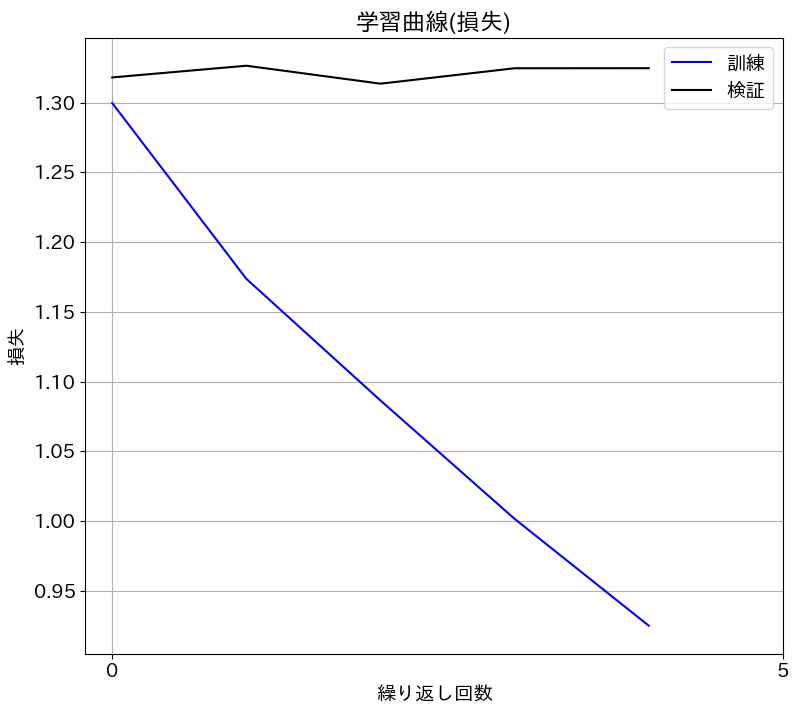

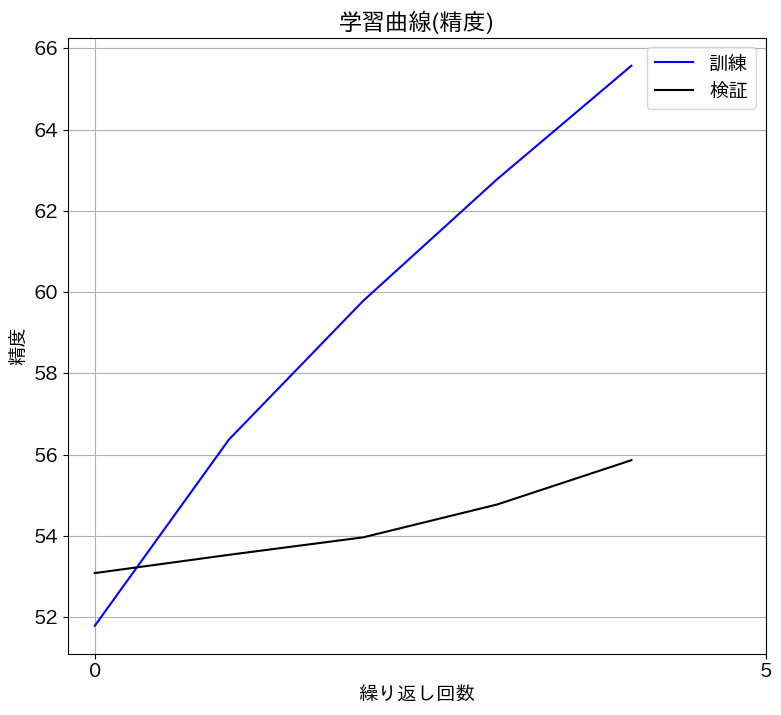

In [ ]:
!pip install japanize_matplotlib | tail -n 1

import matplotlib.pyplot as plt
import japanize_matplotlib

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)



# 学習曲線の表示 (損失)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xticks(np.arange(0,num_epochs+1, 5))
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

# 学習曲線の表示 (精度)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xticks(np.arange(0,num_epochs+1, 5))
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [ ]:
import csv
# CSVファイルの準備
with open(csvname, 'w', newline='') as csvfile:
    fieldnames = ['epoch', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy', 'train_time', 'avg_train_time', 'inference_time', 'avg_inference_time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in history:
        writer.writerow({
            'epoch': row[0],
            'train_loss': row[1],
            'train_accuracy': row[2],
            'test_loss': row[3],
            'test_accuracy': row[4],
            'train_time': row[5],
            'avg_train_time': row[6],
            'inference_time': row[7],
            'avg_inference_time': row[8],
        })

 # writer.writerow({'epoch': epoch + 1, 'batch': '', 'train_loss': '', 'train_accuracy': '', 'test_loss': test_loss, 'test_accuracy': test_accuracy})

In [ ]:
from google.colab import files

filename = f'/content/{csvname}'
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>